In [87]:
# Libraries import

!python3 -m spacy download en_core_web_sm

import pandas as pd 
import numpy as np

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

import spacy
from spacy.lang.en.stop_words import STOP_WORDS

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
     |████████████████████████████████| 12.8 MB 116 kB/s eta 0:00:01    |██████████▋                     | 4.3 MB 1.0 MB/s eta 0:00:09
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [62]:
# Dataset import
dataset = pd.read_csv("train.csv")

# BASIC EXPLORATION

In [63]:
# Getting number of rows and columns of dataset

dataset.shape

(7613, 5)

In [64]:
# Printing first 5 rows of dataset

dataset.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [65]:
# Getting all statistics of dataset

dataset.describe(include='all')

,id,keyword,location,text,target
count,7613.000000,7552,5080,7613,7613.00000
unique,NaN,221,3341,7503,NaN
top,NaN,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...,NaN
freq,NaN,45,104,10,NaN
mean,5441.934848,NaN,NaN,NaN,0.42966
std,3137.116090,NaN,NaN,NaN,0.49506
min,1.000000,NaN,NaN,NaN,0.00000
25%,2734.000000,NaN,NaN,NaN,0.00000
50%,5408.000000,NaN,NaN,NaN,0.00000
75%,8146.000000,NaN,NaN,NaN,1.00000


In [66]:
# Printing more info about dataset

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


# EDA

In [67]:
count = dataset['target'].value_counts()

fig = px.bar(count,
             y='target',
             labels={
                     "target": "Count",
                     "index": "Target"
                 },
             title="Count of tweets describing a real disaster (1) or not (0)")

fig.show()

We can see clearly that there is more tweets about not a real disaster that about a real one.

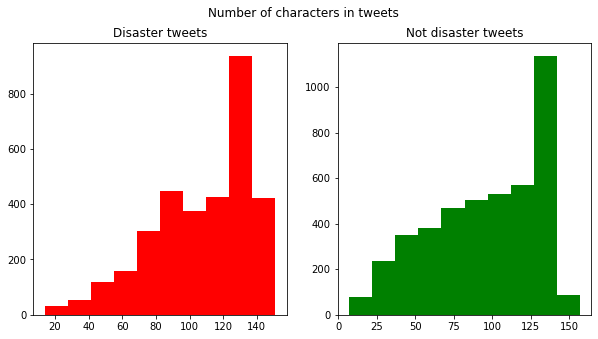

In [91]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len= dataset[dataset['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('Disaster tweets')
tweet_len= dataset[dataset['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Number of characters in tweets')
plt.show()

We can see that in both cases (real disaster or not) the number of characters range is between 120 and 140 characters.

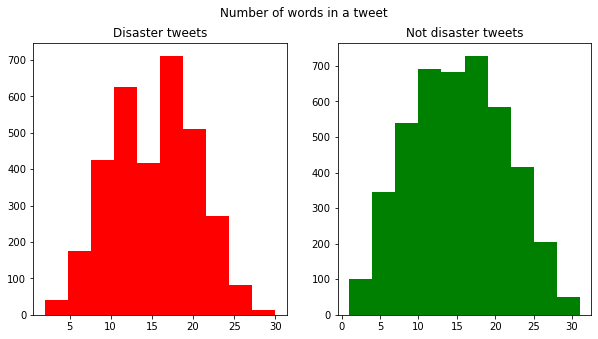

In [92]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len= dataset[dataset['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('Disaster tweets')
tweet_len= dataset[dataset['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Number of words in a tweet')
plt.show()

We can see here a difference of homogeneity in terms of number of words in a tweet. Tweets about not real disaster are more
homogeneous and contain more words through the range that tweet about real disaster.

Text(0.5, 0.98, 'Average word length in each tweet')

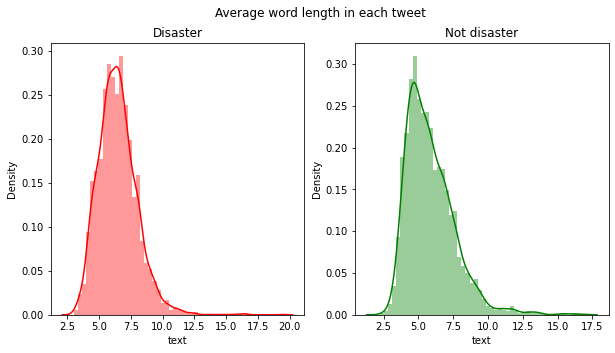

In [94]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=dataset[dataset['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Disaster')
word=dataset[dataset['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

Again here we can notice a difference in homogeneity between both cases and again tweets that are not about a real disaster
seems to be more homogeneous. However, by taking the average this trend seems to be smoothing out.

# PREPROCESSING

In [68]:
# Import the english language model
nlp = spacy.load("en_core_web_sm")
# Creation of a new column that contain clean tweets and deleting non int or spaces
dataset["clean_tweet"] = dataset["text"].apply(lambda x:"".join(letter for letter in x if letter.isalnum() or letter == " "))
# Lower cases all letters and delete the start and end spaces of the tweet
dataset["clean_tweet"] = dataset["clean_tweet"].apply(lambda x: x.lower().strip())
# Delete urls 
dataset["clean_tweet"] = dataset['clean_tweet'].str.replace(r"http.*","")
# Lematization of tweets to keep only the roots 
dataset["clean_tweet"] = dataset["clean_tweet"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]))

In [69]:
# Verifying that the preprocessing went well
dataset.clean_tweet.value_counts()

                                                                                            59
watch airport swallow sandstorm minute                                                      24
like youtube video                                                                          23
wreckage conclusively confirm mh370 malaysia pm investigator family                         20
family sue legionnaire 40 family affect fatal outbreak legionnaire disea                    19
                                                                                            ..
fear panic air want free desolation despair                                                  1
josephus wrong antiochus epiphane abomination desolation read                                1
watch desolation smaug spanish hell drug                                                     1
wow win free hobbit desolation smaug uv digital download code gin 9                          1
suicide bomber kill 15 saudi security site mosque 

In [70]:
# Cleaning it
clean = dataset.clean_tweet.apply(lambda x: type(x)==str)
# Verifying
clean.value_counts()

True    7613
Name: clean_tweet, dtype: int64

In [71]:
# Filter dataset
dataset = dataset.loc[clean,:]
dataset

,id,keyword,location,text,target,clean_tweet
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfire evacuation order...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got send photo ruby alaska smoke wildfire pour...
...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,giant crane hold bridge collapse nearby home
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,ariaahrary thetawniest control wild fire calif...
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,m194 0104 utc5 km s volcano hawaii
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,police investigate ebike collide car little po...


In [72]:
# Instanciating the tokenizer and set up him to keep only the 1000 most common words
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = 1000)
# Fit on the column regarding the clean tweets
tokenizer.fit_on_texts(dataset.clean_tweet)
# Create a new column containing clean tweets but tokenized and so encoded
dataset["clean_tweets_encoded"] = tokenizer.texts_to_sequences(dataset.clean_tweet)
dataset

,id,keyword,location,text,target,clean_tweet,clean_tweets_encoded
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive,"[398, 226]"
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[126, 2, 157, 489]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...,"[425, 340, 275, 187, 340, 267, 379]"
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfire evacuation order...,"[7, 69, 187, 267, 34]"
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got send photo ruby alaska smoke wildfire pour...,"[246, 176, 127, 164, 69, 103]"
...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,giant crane hold bridge collapse nearby home,"[644, 902, 296, 234, 38, 467, 25]"
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,ariaahrary thetawniest control wild fire calif...,"[542, 208, 2, 34, 131, 179]"
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,m194 0104 utc5 km s volcano hawaii,"[421, 5, 468]"
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,police investigate ebike collide car little po...,"[23, 712, 94, 45, 199, 903, 74]"


In [73]:
# We need to standardize the length of encoded clean tweets into a single one numpy array and choose to add zero padding at the end of sequences
encoded_tweets_standardized = tf.keras.preprocessing.sequence.pad_sequences(dataset.clean_tweets_encoded, padding = "post")

In [74]:
print(encoded_tweets_standardized)

[[398 226   0 ...   0   0   0]
 [126   2 157 ...   0   0   0]
 [425 340 275 ...   0   0   0]
 ...
 [421   5 468 ...   0   0   0]
 [ 23 712  94 ...   0   0   0]
 [104  25 365 ...   0   0   0]]


In [75]:
# Splitting dataset into train and test set
X_train, X_val, Y_train, Y_val = train_test_split(encoded_tweets_standardized,dataset.target, test_size = 0.3, random_state = 0)

In [76]:
# Creation of the tensor dataset for the training and validation set
train = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
val = tf.data.Dataset.from_tensor_slices((X_val, Y_val))

In [77]:
# Shuffle data and create batch on both set
train_batch = train.shuffle(len(train)).batch(64)
val_batch = val.shuffle(len(val)).batch(64)

In [78]:
# Checking a batch of data
for tweet, signification in train_batch.take(1):
  print(tweet, signification)

tf.Tensor(
[[707 164 413 ...   0   0   0]
 [ 59 214   5 ...   0   0   0]
 [  3 185   1 ...   0   0   0]
 ...
 [416 269 779 ...   0   0   0]
 [ 10  22  82 ...   0   0   0]
 [180   0   0 ...   0   0   0]], shape=(64, 18), dtype=int32) tf.Tensor(
[1 0 0 0 1 0 1 0 1 1 0 1 0 1 0 1 0 1 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0
 1 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 1 1 0 0 0 1 1], shape=(64,), dtype=int64)


# Model n°1 | 3 dense layers

In [79]:
# Defining the size of the vocabulary in the model (1000)
vocab_size = tokenizer.num_words + 1

# Defining a text classifier model
model = tf.keras.Sequential([
    Embedding(vocab_size, 64, input_shape= [18], name="embedding"),
    tf.keras.layers.GlobalAveragePooling1D(),
    Dense(32, activation='relu'),
    Dense(16, activation="relu"),
    Dense(1, activation='sigmoid')  # Binary classification between 0 and 1
])

# Defining a configuration set to compile the model before training
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=Adam(learning_rate=0.0001),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

# Display a summarize of the model
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 18, 64)            64064     
                                                                 
 global_average_pooling1d_8   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_27 (Dense)            (None, 32)                2080      
                                                                 
 dense_28 (Dense)            (None, 16)                528       
                                                                 
 dense_29 (Dense)            (None, 1)                 17        
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
__________________________________________________

In [80]:
# Model training
history = model.fit(
    train_batch,
    epochs=50,
    validation_data= val_batch)

Epoch 1/50
84/84 [==============================] - 3s 5ms/step - loss: 0.6914 - binary_accuracy: 0.5564 - val_loss: 0.6888 - val_binary_accuracy: 0.5858
Epoch 2/50
84/84 [==============================] - 0s 3ms/step - loss: 0.6880 - binary_accuracy: 0.5637 - val_loss: 0.6841 - val_binary_accuracy: 0.5858
Epoch 3/50
84/84 [==============================] - 0s 3ms/step - loss: 0.6823 - binary_accuracy: 0.5637 - val_loss: 0.6752 - val_binary_accuracy: 0.5858
Epoch 4/50
84/84 [==============================] - 0s 5ms/step - loss: 0.6743 - binary_accuracy: 0.5665 - val_loss: 0.6662 - val_binary_accuracy: 0.5928
Epoch 5/50
84/84 [==============================] - 1s 6ms/step - loss: 0.6650 - binary_accuracy: 0.5840 - val_loss: 0.6551 - val_binary_accuracy: 0.6235
Epoch 6/50
84/84 [==============================] - 0s 6ms/step - loss: 0.6532 - binary_accuracy: 0.6121 - val_loss: 0.6421 - val_binary_accuracy: 0.6423
Epoch 7/50
84/84 [==============================] - 0s 4ms/step - loss: 0.63

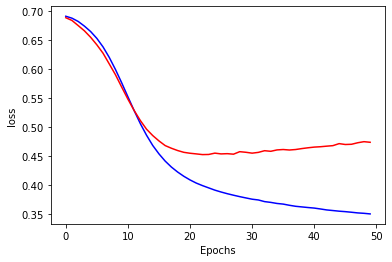

In [81]:
# Visualization of the training process for the loss
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

Scores for 100 epochs:

loss: 0.3505 | val_loss: 0.4740

binary_accuracy: 0.8461 | val_binary_accuracy: 0.7938

# Model n°2 | 6 layers | 5 dropout layers

In [82]:
# Defining the size of the vocabulary in the model (1000)
vocab_size = tokenizer.num_words + 1

# Defining a text classifier model
model2 = tf.keras.Sequential([
    Embedding(vocab_size, 64, input_shape= [18], name="embedding"),
    tf.keras.layers.GlobalAveragePooling1D(),
    Dense(256, activation='relu'),
    Dropout(0.25),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(64, activation='relu'),
    Dropout(0.25),
    Dense(32, activation='relu'),
    Dropout(0.25),
    Dense(16, activation="relu"),
    Dropout(0.25),
    Dense(1, activation='sigmoid')  # Binary classification between 0 and 1
])

# Defining a configuration set to compile the model before training
model2.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=Adam(learning_rate=0.0001),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

# Display a summarize of the model
model2.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 18, 64)            64064     
                                                                 
 global_average_pooling1d_9   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_30 (Dense)            (None, 256)               16640     
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_31 (Dense)            (None, 128)               32896     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                      

In [83]:
# Model training
history2 = model2.fit(
    train_batch,
    epochs=50,
    validation_data= val_batch)

Epoch 1/50
84/84 [==============================] - 2s 11ms/step - loss: 0.6933 - binary_accuracy: 0.5031 - val_loss: 0.6925 - val_binary_accuracy: 0.5858
Epoch 2/50
84/84 [==============================] - 1s 8ms/step - loss: 0.6924 - binary_accuracy: 0.5633 - val_loss: 0.6918 - val_binary_accuracy: 0.5858
Epoch 3/50
84/84 [==============================] - 1s 6ms/step - loss: 0.6919 - binary_accuracy: 0.5637 - val_loss: 0.6909 - val_binary_accuracy: 0.5858
Epoch 4/50
84/84 [==============================] - 1s 6ms/step - loss: 0.6912 - binary_accuracy: 0.5637 - val_loss: 0.6899 - val_binary_accuracy: 0.5858
Epoch 5/50
84/84 [==============================] - 1s 7ms/step - loss: 0.6903 - binary_accuracy: 0.5641 - val_loss: 0.6880 - val_binary_accuracy: 0.5858
Epoch 6/50
84/84 [==============================] - 1s 7ms/step - loss: 0.6887 - binary_accuracy: 0.5631 - val_loss: 0.6841 - val_binary_accuracy: 0.5858
Epoch 7/50
84/84 [==============================] - 1s 10ms/step - loss: 0.

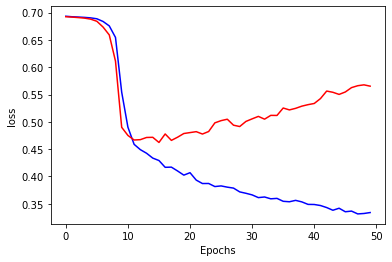

In [84]:
# Visualization of the training process for the loss
plt.plot(history2.history["loss"], color="b")
plt.plot(history2.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

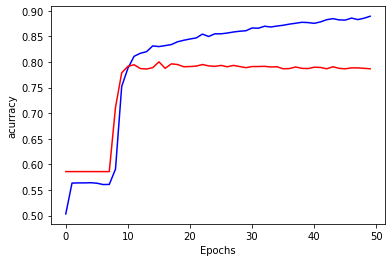

In [85]:
# Visualization of the training process for the accuracy
plt.plot(history2.history["binary_accuracy"], color="b")
plt.plot(history2.history["val_binary_accuracy"], color="r")
plt.ylabel("acurracy")
plt.xlabel("Epochs")
plt.show()

Scores for 100 epochs:

loss: 0.3338 | val_loss: 0.5653

binary_accuracy: 0.8895 | val_binary_accuracy: 0.7868

Conclusion:

The two models results are nearly the same for the accuracy but the second model have more loss and perform less than the first one.

The first model with fewer layers and no dropout layers is indeed the better one to classify tweets.